### Imports

In [1]:
import numpy as np
import spacy
from sklearn.cluster import DBSCAN
import time

In [4]:
def lc_substring(x, y):
    m, n = len(x), len(y)
    lcs = np.zeros((m,n))
    result = 0
    
    for i in range(0,m):
        for j in range(0,n):
            if x[i] == y[j]:
                lcs[i,j] = lcs[i-1,j-1] + 1
                if lcs[i,j] > result:
                    result = lcs[i,j]
            else:
                lcs[i,j] = 0

    return int(result)

In [5]:
def n_gram(x, n):
    return [x[i:n + i] for i in range(len(x) - n + 1)]

In [6]:
def lcs_metric(x, y):
    return 1 - lc_substring(x,y) / max(len(x), len(y))

def dice_metric(x, y, n):
    x_gram = set(n_gram(x, n))
    y_gram = set(n_gram(y, n))
    return 1 - 2*len(x_gram & y_gram) / (len(x_gram) + len(y_gram))
    
def word_to_vec(x):
    res = dict()
    for c in x:
        res[c] = res.get(c, 0) + 1
    return res
    
def cos_metric(x, y):
    x_vec = word_to_vec(x)
    y_vec = word_to_vec(y)

    intersection = set(x_vec) & set(y_vec)
    numerator = sum([x_vec[a] * y_vec[a] for a in intersection])
    
    x_sum = sum([x_vec[x]**2 for x in x_vec])
    y_sum = sum([y_vec[y]**2 for y in y_vec])
    denominator = np.sqrt(x_sum) * np.sqrt(y_sum)

    if denominator > 0:
        return abs(1 - (numerator / denominator)) # ~ -x.xxxe-16
    else:
        return 0.0

def euclidean_metric(x, y):
    x_vec = word_to_vec(x)
    y_vec = word_to_vec(y)
    intersection = set(x_vec) & set(y_vec)
    return np.sqrt(sum([(x_vec[a] - y_vec[a])**2 for a in intersection])) / max(len(x), len(y))
    

In [26]:
def sigma(a,b):
    return not a == b

def levenshtein_metric(x, y):
    m, n = len(x), len(y)
    edit = [[0]*(n+1) for i in range(m+1)]
    
    edit[0][0] = 0
    for i in range(1,m+1):
        edit[i][0] = i
    for j in range(1,n+1):
        edit[0][j] = j
    
    if n == 0 and m == 0:
        return edit[0][0]
    
    for i in range(1,m+1):
        for j in range(1,n+1):
            a = edit[i-1][j] + 1
            b = edit[i][j-1] + 1
            c = edit[i-1][j-1] + sigma(x[i-1], y[j-1])
            if a < b and a < c:
                edit[i][j] = a
            elif b < c:
                edit[i][j] = b
            else:
                edit[i][j] = c

    
    return (edit[m][n] / max(len(x), len(y)))

# Clusterization quality

## Davies-Bouldin index

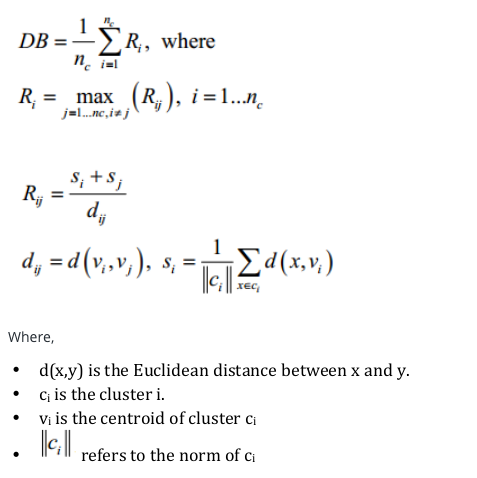

In [8]:
from IPython.display import Image
Image("dbi.png")

In [9]:
def get_s(cluster, centroid, dst_method, n_gram=None):
    c_norm = len(cluster) # nie wiem jak to obliczyć
    if n_gram is None:
        s = sum(dst_method(c, centroid) for c in cluster)
    else:
        s = sum(dst_method(c, centroid, n_gram) for c in cluster)
    return s / c_norm

def get_r(i, j, clusters, centroids, dst_method, n_gram=None):
    if n_gram is None:
        d = dst_method(centroids[i], centroids[j])
    else:
        d = dst_method(centroids[i], centroids[j], n_gram)
    s1 = get_s(clusters[i], centroids[i], dst_method, n_gram)
    s2 = get_s(clusters[j], centroids[j], dst_method, n_gram)
    if d != 0:
        return (s1 + s2) / d 
    else:
        return 0.0
    
# Davies-Bouldin index
def dbi(clusters, centroids, dst_method, n_gram=None):
    n = len(clusters)
    numerator = sum([max([get_r(i, j, clusters, centroids, dst_method, n_gram) for i in range(n) for j in range(n) if i!=j])]) 
    return numerator / n
    

## Dunn index

In [10]:
def dst_between(C1, C2, dst_method, n_gram=None):
    if n_gram is None:
        return dst_method(C1, C2)
    else:
        return dst_method(C1, C2, n_gram)

# Dunn index
# Distance between clusters => distance between centroids
def di(clusters, centroids, dst_method, n_gram=None):
    n = len(centroids)
    if n_gram is None:
        numerator = min([dst_between(centroids[i], centroids[j], dst_method) for i in range(n) for j in range(n) if i!=j])
    else:
        numerator = min([dst_between(centroids[i], centroids[j], dst_method, n_gram) for i in range(n) for j in range(n) if i!=j])
    denominator = max(len(cluster) for cluster in clusters)
    return numerator / denominator

# Stoplist

In [11]:
def get_stoplist(lines_tokens, alpha=0.8):
    w_freq = dict()
    max_val = 0
    for line_tokens in lines_tokens:
        for token in line_tokens:
            val = w_freq.get(token.text, 0) + 1
            w_freq[token.text] = val
            if val > max_val:
                max_val = val
    
    res = list()
    for word, freq in w_freq.items():
        if freq > alpha * max_val:
            res.append(word)
    return res

def lines_without_stopwords(lines_tokens, stoplist):
    res = []
    for line_tokens in lines_tokens:
        new_line = [token.text for token in line_tokens if token.text not in stoplist]
        res.append(" ".join(new_line))
    return res

## Text file

In [12]:
with open("lines_100.txt", "r") as f:
    lines = f.readlines()
nlp = spacy.load("pl_core_news_sm")
n = len(lines)
lines_tokens = []
for i in range(n):
    lines_tokens.append(list(nlp.tokenizer(lines[i])))

text_stoplist = get_stoplist(lines_tokens, alpha=0.6)
lines_no_stopwords = lines_without_stopwords(lines_tokens, text_stoplist)

# DBSCAN clustering

In [13]:
def get_dist_matrix(lines, dst_method, n_gram=None):
    n = len(lines)
    dst_matrix = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                if n_gram is None:
                    dst_matrix[i,j] = dst_method(lines[i], lines[j])
                else:
                    dst_matrix[i,j] = dst_method(lines[i], lines[j], n_gram)
    return dst_matrix

def get_centroids(clusters, dst_method, n_gram=None):
    centroids = []
    for cluster in clusters:
        nc = len(cluster)
        if nc == 1:
            centroids.append(cluster[0])
            continue
        
        one_to_all_mean_dst = []
        for i in range(nc):
            if n_gram is None:
                one_to_all_mean_dst.append(sum([dst_method(cluster[i], cluster[j]) for j in range(nc)]) / nc)
            else:
                one_to_all_mean_dst.append(sum([dst_method(cluster[i], cluster[j], n_gram) for j in range(nc)]) / nc)
        mean_dst = sum(one_to_all_mean_dst) / nc
        centroid = one_to_all_mean_dst[0]
        c_idx = 0
        for i in range(1, nc):
            if centroid < one_to_all_mean_dst[i] <= mean_dst or mean_dst <= one_to_all_mean_dst[i] < centroid:
                centroid = one_to_all_mean_dst[i]
                c_idx = i
        centroids.append(cluster[c_idx])
    return centroids

def clusterize(lines, dst_method, n_gram=None, eps=0.30, min_samples=1):
    dst_matrix = get_dist_matrix(lines, dst_method, n_gram)
    model = DBSCAN(eps, min_samples, metric='precomputed').fit(dst_matrix)
    labels = model.labels_
    nc = len(np.unique(labels))
    
    clusters = [[] for i in range(nc)]
    for i in range(len(labels)):
        clusters[labels[i]].append(lines[i])
    
    centroids = get_centroids(clusters, dst_method, n_gram)
    
    return clusters, centroids



def show_results(clusters):
    for cluster in clusters:
        print("################")
        for c in cluster:
            print(c)
        print()

# Lines number : 100 

### Lcs metric

In [15]:
now = time.time()
clusters_lcs, centroids_lcs = clusterize(lines, lcs_metric, eps=0.70, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_lcs)

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TIME :  25.87486720085144
################
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA


################
''PA INTERIOR'' LTD BOLSHAYA LUBYANKA STREET, 16/4 MOSCOW, 101000, RUSSIA INN/KPP 7704550148//770801001 495-984-8611


################
''SSONTEX''  Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--


################
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4  02-285 WARSZAWA POLAND


################
'MASTER PLUS CO.,LTD.' 143000,RUSSIA,MO,ODINSOVO, MOJAISKOE, SHOSSE,153G TEL:+7495 7273939


################
"2TIGERS GROUP LIMITED"  ROOM 504 JINSHAZHOU SHANGSHUI ROAD,  GUANGZHOU 510160


################
"ALDETRANS" LLC, 105066, MOSCOW, RUSSIA, TOKMAKOV LANE, 11. TEL:+7(495)641-03-89


################
"A-LIFT",JSC 1 PROSPEKT MARSHALA ZHUKOVA,MOSCOW 12

### Lcs metric stoplist

In [16]:
now = time.time()
clusters_lcs_stoplist, centroids_lcs_stoplist = clusterize(lines_no_stopwords, lcs_metric, eps=0.70, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_lcs_stoplist)

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TIME :  26.068248987197876
################
/11692589 RD TUNA CANNERS LTD PORTION 1004 SIAR NORTH COAST ROAD P O BOX 2113 MADANG PAPUA NEW GUINEA 


################
'' PA INTERIOR '' LTD BOLSHAYA LUBYANKA STREET 16/4 MOSCOW 101000 RUSSIA INN / KPP 7704550148//770801001 495 984 8611 


################
'' SSONTEX ''   Sp ZO O IMPORT EXPORTUL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 

'' SSONTEX''SP ZO O IMPORT EXPORT UL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 TEL./FAX.:0048(022)217 6532 


################
'' TOPEX SP Z O.O '' SPOLKA KOMANDYTOWA UL POGRANICZNA 2/4   02 285 WARSZAWA POLAND 


################
' MASTER PLUS CO.,LTD ' 143000,RUSSIA MO ODINSOVO MOJAISKOE SHOSSE,153 G TEL:+7495 7273939 


################
2TIGERS GROUP LIMITED   ROOM 504 JINSHAZHOU SHANGSHUI ROAD   GUANGZHOU 510160 


################
ALDETRANS LLC 105066 MOSCOW RUSSIA TOKMAKOV LANE 11 TEL:+7(495)641 03 89 


################
A LIFT",JSC 1 PROSPEKT MARSHALA ZHUKOVA MOSCOW 12

### Dice metric

In [17]:
now = time.time()
clusters_dice, centroids_dice = clusterize(lines, dice_metric, n_gram=2, eps=0.40, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_dice)

TIME :  0.5068528652191162
################
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA


################
''PA INTERIOR'' LTD BOLSHAYA LUBYANKA STREET, 16/4 MOSCOW, 101000, RUSSIA INN/KPP 7704550148//770801001 495-984-8611


################
''SSONTEX''  Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--

"SSONTEX" SP.ZO.O IMPORT-EXPORT 03-879 WARSZAWA UL PRZECLAWSKA 5 NIP:113-01-17-669


################
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4  02-285 WARSZAWA POLAND


################
'MASTER PLUS CO.,LTD.' 143000,RUSSIA,MO,ODINSOVO, MOJAISKOE, SHOSSE,153G TEL:+7495 7273939


################
"2TIGERS GROUP LIMITED"  ROOM 504 JINSHAZHOU SHANGSHUI ROAD,  GUANGZHOU 510160


################
"ALDETRANS" LLC, 105066, MOSCOW, RUSSIA, TOKMAKOV LANE, 11. TEL:+

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


### Dice metric stoplist

In [18]:
now = time.time()
clusters_dice_stoplist, centroids_dice_stoplist = clusterize(lines_no_stopwords, dice_metric, n_gram=2, eps=0.40, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_dice_stoplist)

TIME :  0.4792037010192871
################
/11692589 RD TUNA CANNERS LTD PORTION 1004 SIAR NORTH COAST ROAD P O BOX 2113 MADANG PAPUA NEW GUINEA 


################
'' PA INTERIOR '' LTD BOLSHAYA LUBYANKA STREET 16/4 MOSCOW 101000 RUSSIA INN / KPP 7704550148//770801001 495 984 8611 


################
'' SSONTEX ''   Sp ZO O IMPORT EXPORTUL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 

'' SSONTEX''SP ZO O IMPORT EXPORT UL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 TEL./FAX.:0048(022)217 6532 

SSONTEX SP ZO O IMPORT EXPORT 03 879 WARSZAWA UL PRZECLAWSKA 5 NIP:113 01 17 669 


################
'' TOPEX SP Z O.O '' SPOLKA KOMANDYTOWA UL POGRANICZNA 2/4   02 285 WARSZAWA POLAND 


################
' MASTER PLUS CO.,LTD ' 143000,RUSSIA MO ODINSOVO MOJAISKOE SHOSSE,153 G TEL:+7495 7273939 


################
2TIGERS GROUP LIMITED   ROOM 504 JINSHAZHOU SHANGSHUI ROAD   GUANGZHOU 510160 


################
ALDETRANS LLC 105066 MOSCOW RUSSIA TOKMAKOV LANE 11 TEL:+7(

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


### Cosinus metric

In [19]:
now = time.time()
clusters_cos, centroids_cos = clusterize(lines, cos_metric, eps=0.05, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_cos)

TIME :  0.575068473815918
################
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA


################
''PA INTERIOR'' LTD BOLSHAYA LUBYANKA STREET, 16/4 MOSCOW, 101000, RUSSIA INN/KPP 7704550148//770801001 495-984-8611


################
''SSONTEX''  Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--

"SSONTEX" SP.ZO.O IMPORT-EXPORT 03-879 WARSZAWA UL PRZECLAWSKA 5 NIP:113-01-17-669


################
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4  02-285 WARSZAWA POLAND


################
'MASTER PLUS CO.,LTD.' 143000,RUSSIA,MO,ODINSOVO, MOJAISKOE, SHOSSE,153G TEL:+7495 7273939


################
"2TIGERS GROUP LIMITED"  ROOM 504 JINSHAZHOU SHANGSHUI ROAD,  GUANGZHOU 510160


################
"ALDETRANS" LLC, 105066, MOSCOW, RUSSIA, TOKMAKOV LANE, 11. TEL:+7

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


### Cosinus metric stoplist

In [20]:
now = time.time()
clusters_cos_stoplist, centroids_cos_stoplist = clusterize(lines_no_stopwords, cos_metric, eps=0.05, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_cos_stoplist)

TIME :  0.6037521362304688
################
/11692589 RD TUNA CANNERS LTD PORTION 1004 SIAR NORTH COAST ROAD P O BOX 2113 MADANG PAPUA NEW GUINEA 


################
'' PA INTERIOR '' LTD BOLSHAYA LUBYANKA STREET 16/4 MOSCOW 101000 RUSSIA INN / KPP 7704550148//770801001 495 984 8611 


################
'' SSONTEX ''   Sp ZO O IMPORT EXPORTUL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 

'' SSONTEX''SP ZO O IMPORT EXPORT UL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 TEL./FAX.:0048(022)217 6532 

SSONTEX SP ZO O IMPORT EXPORT 03 879 WARSZAWA UL PRZECLAWSKA 5 NIP:113 01 17 669 


################
'' TOPEX SP Z O.O '' SPOLKA KOMANDYTOWA UL POGRANICZNA 2/4   02 285 WARSZAWA POLAND 


################
' MASTER PLUS CO.,LTD ' 143000,RUSSIA MO ODINSOVO MOJAISKOE SHOSSE,153 G TEL:+7495 7273939 


################
2TIGERS GROUP LIMITED   ROOM 504 JINSHAZHOU SHANGSHUI ROAD   GUANGZHOU 510160 


################
ALDETRANS LLC 105066 MOSCOW RUSSIA TOKMAKOV LANE 11 TEL:+7(

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


### Euclidean metric

In [21]:
now = time.time()
clusters_euclidean, centroids_euclidean = clusterize(lines, euclidean_metric, eps=0.05, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_euclidean)

TIME :  0.4567732810974121
################
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA


################
''PA INTERIOR'' LTD BOLSHAYA LUBYANKA STREET, 16/4 MOSCOW, 101000, RUSSIA INN/KPP 7704550148//770801001 495-984-8611


################
''SSONTEX''  Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--

"SSONTEX" SP.ZO.O IMPORT-EXPORT 03-879 WARSZAWA UL PRZECLAWSKA 5 NIP:113-01-17-669


################
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4  02-285 WARSZAWA POLAND


################
'MASTER PLUS CO.,LTD.' 143000,RUSSIA,MO,ODINSOVO, MOJAISKOE, SHOSSE,153G TEL:+7495 7273939


################
"2TIGERS GROUP LIMITED"  ROOM 504 JINSHAZHOU SHANGSHUI ROAD,  GUANGZHOU 510160


################
"ALDETRANS" LLC, 105066, MOSCOW, RUSSIA, TOKMAKOV LANE, 11. TEL:+

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


### Euclidean metric stoplist

In [22]:
now = time.time()
clusters_euclidean_stoplist, centroids_euclidean_stoplist = clusterize(lines_no_stopwords, euclidean_metric, eps=0.05, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_euclidean_stoplist)

TIME :  0.4296286106109619
################
/11692589 RD TUNA CANNERS LTD PORTION 1004 SIAR NORTH COAST ROAD P O BOX 2113 MADANG PAPUA NEW GUINEA 


################
'' PA INTERIOR '' LTD BOLSHAYA LUBYANKA STREET 16/4 MOSCOW 101000 RUSSIA INN / KPP 7704550148//770801001 495 984 8611 


################
'' SSONTEX ''   Sp ZO O IMPORT EXPORTUL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 

'' SSONTEX''SP ZO O IMPORT EXPORT UL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 TEL./FAX.:0048(022)217 6532 


################
'' TOPEX SP Z O.O '' SPOLKA KOMANDYTOWA UL POGRANICZNA 2/4   02 285 WARSZAWA POLAND 


################
' MASTER PLUS CO.,LTD ' 143000,RUSSIA MO ODINSOVO MOJAISKOE SHOSSE,153 G TEL:+7495 7273939 


################
2TIGERS GROUP LIMITED   ROOM 504 JINSHAZHOU SHANGSHUI ROAD   GUANGZHOU 510160 


################
ALDETRANS LLC 105066 MOSCOW RUSSIA TOKMAKOV LANE 11 TEL:+7(495)641 03 89 


################
A LIFT",JSC 1 PROSPEKT MARSHALA ZHUKOVA MOSCOW 12

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


### Levenshtein metric

In [27]:
now = time.time()
clusters_levenshtein, centroids_levenshtein = clusterize(lines, levenshtein_metric, eps=0.40, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_levenshtein)

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TIME :  74.22279667854309
################
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA


################
''PA INTERIOR'' LTD BOLSHAYA LUBYANKA STREET, 16/4 MOSCOW, 101000, RUSSIA INN/KPP 7704550148//770801001 495-984-8611


################
''SSONTEX''  Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--


################
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4  02-285 WARSZAWA POLAND


################
'MASTER PLUS CO.,LTD.' 143000,RUSSIA,MO,ODINSOVO, MOJAISKOE, SHOSSE,153G TEL:+7495 7273939


################
"2TIGERS GROUP LIMITED"  ROOM 504 JINSHAZHOU SHANGSHUI ROAD,  GUANGZHOU 510160


################
"ALDETRANS" LLC, 105066, MOSCOW, RUSSIA, TOKMAKOV LANE, 11. TEL:+7(495)641-03-89


################
"A-LIFT",JSC 1 PROSPEKT MARSHALA ZHUKOVA,MOSCOW 12

### Levenshtein metric stoplist

In [28]:
now = time.time()
clusters_levenshtein_stoplist, centroids_levenshtein_stoplist = clusterize(lines_no_stopwords, levenshtein_metric, eps=0.40, min_samples=1)
print("TIME : ",time.time() - now)
show_results(clusters_levenshtein_stoplist)

C:\Users\Norbert\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass min_samples=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


TIME :  72.86178135871887
################
/11692589 RD TUNA CANNERS LTD PORTION 1004 SIAR NORTH COAST ROAD P O BOX 2113 MADANG PAPUA NEW GUINEA 


################
'' PA INTERIOR '' LTD BOLSHAYA LUBYANKA STREET 16/4 MOSCOW 101000 RUSSIA INN / KPP 7704550148//770801001 495 984 8611 


################
'' SSONTEX ''   Sp ZO O IMPORT EXPORTUL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 

'' SSONTEX''SP ZO O IMPORT EXPORT UL : PRZECLAWSKA 5 03 879 WARSZAWA POLAND NIP 113 01 17 669 TEL./FAX.:0048(022)217 6532 


################
'' TOPEX SP Z O.O '' SPOLKA KOMANDYTOWA UL POGRANICZNA 2/4   02 285 WARSZAWA POLAND 


################
' MASTER PLUS CO.,LTD ' 143000,RUSSIA MO ODINSOVO MOJAISKOE SHOSSE,153 G TEL:+7495 7273939 


################
2TIGERS GROUP LIMITED   ROOM 504 JINSHAZHOU SHANGSHUI ROAD   GUANGZHOU 510160 


################
ALDETRANS LLC 105066 MOSCOW RUSSIA TOKMAKOV LANE 11 TEL:+7(495)641 03 89 


################
A LIFT",JSC 1 PROSPEKT MARSHALA ZHUKOVA MOSCOW 123

# Clusterization quality test

### LCS

In [35]:
print(dbi(clusters_lcs, centroids_lcs, lcs_metric))
print(di(clusters_lcs, centroids_lcs, lcs_metric))

0.01534760987607778
0.11904761904761905


### LCS  stoplist

In [36]:
print(dbi(clusters_lcs_stoplist, centroids_lcs_stoplist, lcs_metric))
print(di(clusters_lcs_stoplist, centroids_lcs_stoplist, lcs_metric))

0.01675962084915398
0.10641399416909622


### Dice

In [29]:
print(dbi(clusters_dice, centroids_dice, dice_metric, n_gram=2))
print(di(clusters_dice, centroids_dice, dice_metric, n_gram=2))

0.009873792305523314
0.04098360655737705


### Dice stoplist

In [30]:
print(dbi(clusters_dice_stoplist, centroids_dice_stoplist, dice_metric, n_gram=2))
print(di(clusters_dice_stoplist, centroids_dice_stoplist, dice_metric, n_gram=2))

0.01575811682158994
0.039555863983344895


### Cosinus

In [31]:
print(dbi(clusters_cos, centroids_cos, cos_metric))
print(di(clusters_cos, centroids_cos, cos_metric))

0.009942823796892642
0.008775843527967422


### Cosinus stoplist

In [32]:
print(dbi(clusters_cos_stoplist, centroids_cos_stoplist, cos_metric))
print(di(clusters_cos_stoplist, centroids_cos_stoplist, cos_metric))

0.023611102724672307
0.0026562994507046134


### Euclidean

In [33]:
print(dbi(clusters_euclidean, centroids_euclidean, euclidean_metric))
print(di(clusters_euclidean, centroids_euclidean, euclidean_metric))

0.014169576450287649
0.0038736903592187996


### Euclidean stoplist

In [34]:
print(dbi(clusters_euclidean_stoplist, centroids_euclidean_stoplist, euclidean_metric))
print(di(clusters_euclidean_stoplist, centroids_euclidean_stoplist, euclidean_metric))

0.00964145594812797
0.01260864451565438


### Levenshtein

In [37]:
print(dbi(clusters_levenshtein, centroids_levenshtein, levenshtein_metric))
print(di(clusters_levenshtein, centroids_levenshtein, levenshtein_metric))

0.00815245299956168
0.059006211180124224


### Levenshtein stoplist

In [38]:
print(dbi(clusters_levenshtein_stoplist, centroids_levenshtein_stoplist, levenshtein_metric))
print(di(clusters_levenshtein_stoplist, centroids_levenshtein_stoplist, levenshtein_metric))

0.007307113690092413
0.059766763848396506


Jedną z lepszych metryk okazała się metryka cosinusowa

### Zad6

Można zamienić LOWER_CASE na UPPER_CASE,
oraz można posortować każdą linię wejściową aby np. metryka Levenshteina
zwracała lepsze odległości.